In this exercise I solve a deterministic growth model using simulated data generated from an economy with parameters $\beta = 0.95$, $\alpha = 0.3$, $A = 1.0$, $\delta = 0.05$, $\gamma = 2.0$. I initiate the variables of the mathematical program at the true values, which should make the optimization easy.

  likely near In[1]:2
  likely near In[1]:2



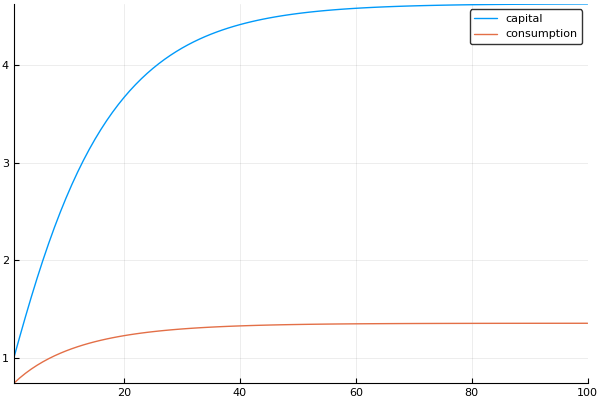

In [1]:
using CSV
using Plots; pyplot()

df = CSV.read("data.csv"; header=false, types=[Float64, Float64])
dataK = convert(Vector{Float64}, df[1])
dataC = convert(Vector{Float64}, df[2])

plot(dataK, label="capital")
plot!(dataC, label="consumption")

The economy's steady state for capital is:

In [2]:
k_stst = 4.628988089138438;

# The Mathematical Program
I define the needed function related to utility and production:

In [56]:
u_crra(c, γ) = begin
    if (c <= 0)
        warn("u_crra_prime")
        return -1000000.
        else
        return c^(1-γ)/(1-γ)
    end
end

u_crra_prime(c, γ) = begin
    if (c <= 0)
        warn("u_crra_prime")
        return -1000000.
        else
        return c^-γ
    end
end

u_crra_prime_inv(u, γ) = begin
    if (u <= 0)
        warn("u_crra_prime_inv")
        return +1000000.
    else
        return u^(-1/γ) 
    end
end

function f(k, α, A)
    if (k <= 0)
        warn("f")
        return zero(k)
    else
        A*k^α
    end
end

function f_prime(k, α, A)
    if (k <= 0)
        warn("f_prime")
        return zero(k)
    else
        A*α*k^(α-1)
    end
end

f_prime (generic function with 1 method)

I use the Julia Mathematical Programming languange JuMP and the IpOpt solver:

In [126]:
using JuMP
using Ipopt

m = Model(solver=IpoptSolver(print_level=5, max_iter=500));

I define the deep parameters variables and give the the correct starting values:

In [127]:
@variable(m, 0 <= β <= 1, start = 0.90)
@variable(m, 0 <= δ <= 1, start = 0.10)
@variable(m, 0 <= α <= 1, start = 0.4)
@variable(m, A >= 0, start = 1)
@variable(m, 100 >= γ >= 1, start = 3);

The policy function is approximated by 12 cubic splines on a grid around the steady state for capital, the coefficients on the polynomials are $\theta$:

I define a grid on capital, $K$, with 12 nodes, and evaluate the spline polynomials at those point into $\Psi$ and at the observed data points into $\Phi$:

In [128]:
using BasisMatrices
global const params = LinParams(10, 0.2*k_stst, 2*k_stst)
basis = Basis(params)
K = nodes(basis)[1]
Ψ = BasisMatrix(basis, Expanded(), K).vals[1]
Ψprime = BasisMatrix(basis, Expanded(), K, 1).vals[1]

Φ = BasisMatrix(basis, Expanded(), dataK).vals[1]
Φprime = BasisMatrix(basis, Expanded(), dataK, 1).vals[1];

In [129]:
@variable(m, θ[1:length(K)], start = 0);

In the equilibrium constraint the polynomials have to be evaluated also outside the grid, I define this function here:

In [130]:
function interpV(x, values...) #x is the point of evaluation, values are on the grid
    return (evalbase(params, [x], 0) * collect(values))[1]
end

interpV (generic function with 1 method)

I register all user-defined functions with JuMP for automatic differentiation:

In [131]:
JuMP.register(m, :interpV, 1+length(K), interpV, autodiff=true)
JuMP.register(m, :u_crra, 2, u_crra, autodiff=true)
JuMP.register(m, :u_crra_prime, 2, u_crra_prime, autodiff=true)
JuMP.register(m, :f, 3, f, autodiff=true)
JuMP.register(m, :f_prime, 3, f_prime, autodiff=true)
JuMP.register(m, :u_crra_prime_inv, 2, u_crra_prime_inv, autodiff=true)

The auxiliary and equilibrium constraints are all defined on the grid with 10 nodes:

In [132]:
@variable(m, modelC[i=1:length(K)] >= 0, start = 1)
@variable(m, modelKprime[i=1:length(K)] >= 0, start = 1)

@NLconstraint(m, cons_today[i=1:length(K)], modelC[i] == u_crra_prime_inv(sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) / 
            (f_prime(modelKprime[i], α, A) + 1-δ), γ))
    
@NLconstraint(m, capi_tomor[i=1:length(K)], modelKprime[i] == f(K[i], α, A) + (1-δ)*K[i] - u_crra_prime_inv(sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) / 
            (f_prime(K[i], α, A) + 1-δ), γ));

And I initialize $\theta$ and the auxiliary variables at the true values:

In [133]:
b2 = Basis(ChebParams(10, 0.2*k_stst, 2*k_stst))
K2 = nodes(b2)[1] #grid
Ψ2 = BasisMatrix(b2, Expanded(), K2).vals[1]
θ2 = Ψ2 \ [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393]
ν  = Ψ \ (BasisMatrix(b2, Expanded(), K).vals[1] * [-15.112, 2.69213, -0.640543, 0.208069, -0.0777003, 0.0304588, -0.0123556, 0.00602886, -0.00329544, 0.00114639])

for i in 1:length(K)
    setvalue(modelC[i], (BasisMatrix(b2, Expanded(), K).vals[1] * θ2)[i])
    setvalue(modelKprime[i], f(K[i], getvalue(α), getvalue(A)) + (1-getvalue(δ))*K[i] - getvalue(modelC[i]))
    setvalue(θ[i], ν[i])
end

The Bellman equation:

In [134]:
@NLconstraint(m, increasing[i=1:length(K)], sum(Ψprime[i, k] * θ[k] for k in 1:length(K)) >= 0)
#@NLconstraint(m, concave[i=1:length(K)], sum(Ψprimeprime[i, k] * θ[k] for k in 1:length(K)) <= 0)

@NLconstraint(m, EE[i=1:length(K)], sum(Ψ[i, k] * θ[k] for k in 1:length(K)) == u_crra(modelC[i], γ) + 
            β * interpV(modelKprime[i], θ[1], θ[2], θ[3], θ[4], θ[5], θ[6], θ[7], θ[8], θ[9], θ[10]));

I define auxiliary expressions for the predictions of the equilibrium conditions:

In [135]:
@NLexpression(m, predictedK[t=2:100], f(dataK[t-1], α, A) + (1-δ)*dataK[t-1] - dataC[t-1])

R = f_prime.(dataK, 0.3, 1.) + 1-0.05
@NLexpression(m, predictedC[t=1:100], u_crra_prime_inv(sum(Φprime[t, k] * θ[k] for k in 1:length(K)) / R[t], γ));

The objective is to minimize the sum of squared errors:

In [136]:
#+ (β-0.95)^2 + (δ-0.05)^2 + (α-0.3)^2 + (A-1)^2 + (γ-2)^2)
@NLobjective(m, Min, sum((dataC[t] - predictedC[t])^2 for t in 1:100) +
    sum((dataK[t] - predictedK[t])^2 for t in 2:100))

In [137]:
solve(m)

This is Ipopt version 3.12.1, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      450
Number of nonzeros in inequality constraint Jacobian.:      100
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       35
                     variables with only lower bounds:       21
                variables with lower and upper bounds:        4
                     variables with only upper bounds:        0
Total number of equality constraints.................:       30
Total number of inequality constraints...............:       10
        inequality constraints with only lower bounds:       10
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

  35  1.4484152e-02 4.84e-02 3.29e-01  -7.4 8.38e+01    -  1.79e-02 2.58e-03h  6
  36  1.6215877e-02 4.51e-02 2.26e+00  -7.4 9.85e-01    -  7.53e-01 8.55e-02h  1
  37  1.2704071e-02 7.54e-03 1.36e+00  -7.4 3.26e-01    -  1.00e+00 1.00e+00f  1
  38  1.2164335e-02 5.48e-04 5.62e-01  -6.3 1.93e-01    -  1.00e+00 1.00e+00h  1
  39  1.3642937e-02 2.64e-04 2.64e+00  -3.7 1.45e+00    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  1.3694912e-02 1.14e-04 2.22e+00  -3.2 2.18e+01    -  1.00e+00 5.87e-03h  6
  41  1.3533183e-02 6.88e-05 2.38e+00  -2.9 2.06e+00    -  1.00e+00 3.12e-02h  6
  42  1.3261063e-02 1.44e-03 2.96e+00  -3.0 3.39e+00    -  1.00e+00 4.17e-02h  3
  43  1.2780643e-02 8.97e-03 4.35e-01  -3.1 8.22e+00    -  6.35e-01 1.01e-01h  4
  44  1.2115596e-02 1.63e-03 1.77e-01  -3.1 2.58e-01    -  1.00e+00 1.00e+00h  1
  45  1.3877803e-02 6.83e-04 2.55e+00  -3.8 6.72e-01    -  9.90e-01 1.00e+00H  1
  46  1.3742821e-02 7.54e-04

u_crra_prime_inv


 176  1.4897869e-02 1.55e-02 1.54e+00  -3.5 3.52e+00    -  5.45e-01 6.25e-02h  5
 177  1.3998731e-02 6.50e-04 2.29e-01  -3.5 1.46e-01    -  1.00e+00 1.00e+00h  1
 178  1.3915810e-02 8.19e-04 3.17e-01  -3.5 1.85e+00    -  9.05e-01 3.09e-02h  6
 179  1.4668598e-02 1.18e-04 1.87e+00  -3.5 4.52e-01    -  1.00e+00 1.00e+00H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  1.4554066e-02 1.83e-04 1.51e+00  -3.5 2.39e+00    -  1.00e+00 3.12e-02h  6
 181  1.3096265e-02 3.19e-03 1.40e-01  -3.5 2.09e+00    -  1.00e+00 1.25e-01h  4
 182  1.2609923e-02 1.89e-03 4.36e-01  -3.5 1.78e-01    -  1.00e+00 1.00e+00h  1
 183  1.2526490e-02 1.99e-03 4.10e-01  -3.5 8.67e+00    -  4.12e-01 9.63e-03h  5
 184  1.2463492e-02 2.85e-03 8.78e-01  -3.5 1.12e+00    -  1.00e+00 1.19e-01h  4
 185  1.2462809e-02 2.77e-03 3.94e-01  -3.5 1.14e+00    -  1.00e+00 3.12e-02h  6
 186  1.2479116e-02 3.60e-03 6.18e-01  -3.5 1.55e+00    -  1.00e+00 1.25e-01h  4
 187  1.2460288e-02 3.59e-03

 219  1.2055099e-02 6.97e-03 4.80e-02  -4.3 3.29e+06    -  2.36e-01 4.25e-04h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220  4.8654999e-02 8.37e-05 5.40e+00  -4.3 5.91e-01    -  9.91e-01 1.00e+00H  1
 221  3.9876464e-02 1.15e-04 2.64e+00  -4.3 8.35e-01    -  1.00e+00 1.25e-01h  4
 222  3.6586535e-02 1.73e-04 3.19e+00  -4.3 1.41e+01    -  5.52e-02 1.77e-03f  7
 223  3.4018407e-02 2.06e-04 3.27e+00  -4.3 2.28e+00    -  1.00e+00 3.12e-02h  6
 224  3.2614751e-02 2.27e-04 3.13e+00  -4.3 4.93e+00    -  8.50e-01 7.81e-03h  8
 225  2.7625623e-02 1.51e-02 2.14e+00  -4.3 1.46e+01    -  4.24e-01 8.46e-02h  3
 226  3.0969540e-02 1.93e-02 3.96e+00  -4.3 2.21e+01    -  1.15e-01 1.27e-02h  1
 227  1.4684728e-02 1.62e-02 1.85e-01  -4.3 9.40e-01    -  1.41e-02 1.00e+00h  1
 228  1.2959041e-02 1.70e-02 1.99e+00  -4.3 1.38e+02    -  1.59e-02 1.75e-03h  5
 229  1.2406512e-02 8.53e-04 3.42e-01  -4.3 4.79e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

 389  1.1774432e-02 3.40e-04 3.50e-02 -11.0 2.48e+01    -  1.81e-01 1.38e-03h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 390  1.1773980e-02 3.45e-04 7.49e-03 -11.0 1.81e+01    -  3.65e-01 8.98e-04h  8
 391  1.1757903e-02 2.41e-06 3.74e-03 -11.0 1.42e-02    -  1.00e+00 1.00e+00h  1
 392  1.1757817e-02 8.57e-09 1.12e-06 -11.0 7.15e-04    -  1.00e+00 1.00e+00h  1
 393  1.1757909e-02 1.10e-09 3.49e-04 -11.0 1.53e-02    -  1.00e+00 1.00e+00H  1
 394  1.1760313e-02 6.05e-11 2.03e-03 -11.0 1.15e-02    -  1.00e+00 1.00e+00H  1
 395  1.1760309e-02 3.50e-07 1.03e-02 -11.0 1.47e-01    -  1.00e+00 1.56e-02h  7
 396  1.1760305e-02 4.46e-07 7.38e-03 -11.0 2.55e+00    -  1.00e+00 9.77e-04h 11


 397  1.1760190e-02 4.84e-06 1.75e-02 -11.0 2.80e+01    -  1.85e-01 5.45e-04h  9
 398  1.1758846e-02 1.27e-05 7.89e-02 -11.0 7.41e+00    -  4.26e-01 3.21e-03h  9
 399  1.1758823e-02 1.29e-05 7.79e-02 -11.0 1.44e+00    -  1.00e+00 1.95e-03h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 400  1.1757848e-02 5.41e-07 4.69e-03 -11.0 4.44e-02    -  1.00e+00 1.00e+00H  1
 401  1.1761931e-02 4.60e-12 1.90e-03 -11.0 1.11e-02    -  1.00e+00 1.00e+00H  1
 402  1.1758197e-02 3.55e-08 5.72e-04 -11.0 3.34e-02    -  1.00e+00 1.00e+00H  1
 403  1.1758180e-02 2.71e-07 9.39e-03 -11.0 3.60e+01    -  1.44e-01 1.20e-04h 11
 404  1.1758104e-02 3.41e-07 2.47e-03 -11.0 5.42e+00    -  1.00e+00 2.71e-04h 12
 405  1.1758623e-02 2.50e-09 3.23e-04 -11.0 6.84e-02    -  1.00e+00 1.00e+00H  1


 406  1.1758620e-02 1.65e-08 3.15e-04 -11.0 1.23e+01    -  2.62e-01 7.92e-05h 13
 407  1.1758607e-02 3.03e-08 3.64e-04 -11.0 5.92e-01    -  1.00e+00 9.77e-04h 11
 408  1.1757833e-02 4.50e-07 1.23e-03 -11.0 4.28e-02    -  1.00e+00 1.00e+00H  1
 409  1.1757832e-02 4.53e-07 2.85e-03 -11.0 2.71e+00    -  9.85e-01 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  1.1757832e-02 4.54e-07 1.96e-03 -11.0 2.08e+00    -  1.00e+00 1.22e-04h 14
 411  1.1757819e-02 4.14e-08 1.40e-05 -11.0 1.30e-03    -  1.00e+00 1.00e+00h  1
 412  1.1757845e-02 2.40e-09 1.43e-04 -11.0 8.33e-03    -  1.00e+00 1.00e+00H  1
 413  1.1757845e-02 1.18e-09 1.44e-04 -11.0 8.32e-01    -  1.00e+00 4.88e-04h 12
 414  1.1758222e-02 1.94e-10 5.24e-04 -11.0 2.46e-02    -  1.00e+00 1.00e+00H  1
 415  1.1758219e-02 7.08e-09 5.52e-04 -11.0 7.95e-02    -  1.00e+00 3.91e-03h  9
 416  1.1774419e-02 3.54e-10 8.51e-03 -11.0 2.23e-02    -  1.00e+00 1.00e+00H  1
 417  1.1774383e-02 3.95e-09

 431  2.6582926e-02 1.23e-01 5.50e+00 -11.0 1.55e+02    -  4.57e-02 3.42e-03h  5
 432  6.8122168e-02 7.38e-02 1.47e+01 -11.0 2.01e-01    -  1.00e+00 4.04e-01h  1
 433  1.9469562e-01 9.69e-03 2.27e+01 -11.0 2.17e-01    -  1.00e+00 1.00e+00h  1
 434  3.8619603e-02 3.35e-03 5.23e+00 -11.0 1.35e-01    -  1.00e+00 1.00e+00h  1
 435  3.7497832e-02 2.76e-04 1.42e-01 -11.0 4.10e-02    -  6.34e-01 1.00e+00h  1
 436  2.2054103e-02 3.38e-03 2.55e+00 -11.0 1.74e-01    -  1.00e+00 1.00e+00h  1
 437  1.3885056e-02 1.74e-03 2.53e+00 -11.0 1.76e-01    -  1.00e+00 1.00e+00h  1
 438  1.7056674e-02 1.24e-04 4.00e+00 -11.0 1.18e-01    -  1.00e+00 1.00e+00H  1
 439  1.2169462e-02 3.17e-03 2.93e-01 -11.0 8.76e-02    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 440  1.1944082e-02 2.72e-04 3.53e-01 -11.0 4.48e-02    -  1.00e+00 1.00e+00h  1
 441  2.1490525e-02 2.51e-05 8.05e+00 -11.0 1.33e-01    -  1.00e+00 1.00e+00H  1
 442  1.3744940e-02 4.24e-05

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  1.1766484e-02 6.75e-05 4.98e-02 -11.0 5.61e+01    -  2.77e-02 9.85e-04f  7
 471  1.1766442e-02 6.80e-05 4.97e-02 -11.0 2.41e+01    -  1.82e-01 2.58e-04h 11
 472  1.1766406e-02 6.86e-05 5.51e-02 -11.0 2.07e+02    -  2.38e-02 2.66e-05h 10
 473  1.1769037e-02 6.40e-05 1.00e-01 -11.0 1.31e-01    -  1.00e+00 1.25e-01h  4
 474  1.1768353e-02 6.56e-05 1.01e-01 -11.0 4.56e+00    -  8.12e-01 1.92e-03h  9
 475  1.1764195e-02 7.95e-06 1.49e-01 -11.0 9.43e-02    -  1.00e+00 1.00e+00H  1
 476  1.1760834e-02 6.01e-06 6.14e-02 -11.0 1.01e-01    -  1.00e+00 1.00e+00H  1
 477  1.1760966e-02 3.11e-06 4.93e-02 -11.0 4.24e+01    -  4.16e-02 3.33e-04h  9
 478  1.1760698e-02 2.92e-06 7.40e-02 -11.0 1.33e+01    -  4.19e-01 6.26e-04h 11
 479  1.1759914e-02 7.79e-06 7.62e-02 -11.0 8.59e+01    -  6.26e-02 2.61e-04h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 480  1.1759889e-02 7.96e-06

 489  1.9365934e-02 1.07e-01 5.16e-01 -11.0 3.27e+01    -  2.14e-01 3.14e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 490  2.0417465e-02 1.07e-01 3.41e+00 -11.0 2.26e+01    -  3.32e-01 7.15e-03h  4
 491  1.5336421e-02 1.39e-02 1.83e+00 -11.0 2.05e+00    -  1.00e+00 1.00e+00h  1
 492  1.5018889e-02 1.39e-02 2.58e+00 -11.0 3.48e+01    -  9.94e-02 9.09e-03h  4
 493  1.2349109e-02 1.06e-03 3.54e-01 -11.0 2.29e-01    -  1.00e+00 1.00e+00h  1
 494  1.2331586e-02 1.31e-03 4.35e-01 -11.0 1.33e+01    -  4.40e-01 9.75e-03h  6
 495  1.2293199e-02 1.54e-03 7.12e-01 -11.0 3.75e+02    -  3.74e-03 2.52e-04h  6
 496  1.2292085e-02 1.54e-03 8.47e-01 -11.0 5.00e+01    -  1.16e-01 2.85e-04h  9
 497  1.1946532e-02 7.08e-05 2.26e-01 -11.0 8.84e-02    -  1.00e+00 1.00e+00h  1
 498  1.1916610e-02 1.29e-03 3.82e-01 -11.0 5.88e+00    -  4.99e-01 3.31e-02h  4
 499  1.1911895e-02 7.64e-04 3.46e-02 -11.0 2.30e-01    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr 

:UserLimit

In [138]:
getvalue(β), getvalue(δ), getvalue(α), getvalue(A), getvalue(γ)

(0.9306641881916856, 0.03779862463759242, 0.28391647070069065, 0.9898026241060709, 3.342392526957198)


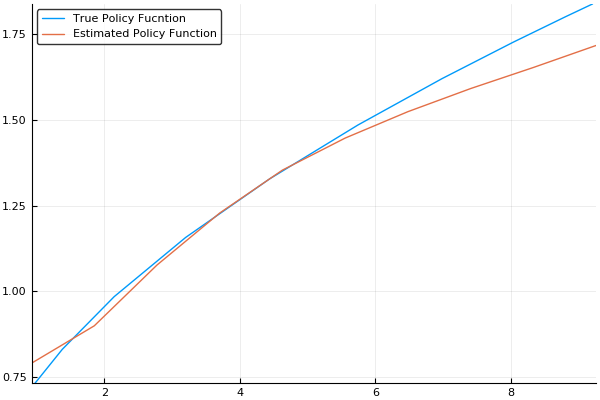

In [139]:
plot(nodes(Basis(ChebParams(10, 0.2*k_stst, 2*k_stst)))[1], [0.731039, 0.830067, 0.984055, 1.15697 , 1.32812 , 1.48555 , 1.62093 , 1.72778 , 1.80161 , 1.8393], label="True Policy Fucntion")
plot!(K, u_crra_prime_inv.((Ψprime * getvalue(θ))./(f_prime.(f.(K, getvalue(α), getvalue(A)) + (1-getvalue(δ))*K - 
            u_crra_prime_inv.((Ψprime * getvalue(θ)) ./ (f_prime.(K, getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ)), getvalue(α), getvalue(A)) + 1-getvalue(δ)), getvalue(γ)), label="Estimated Policy Function")
#plot!(K, getvalue(modelC), label="Estimated Policy Function")

Does not seem fruitfull, compared to slines!